# Regularizing the N-Body Problem
## Miguel Martinez
## ASTRON 441

The purpose of this notebook is to introduce four different ways of providing more accurate numerical solutions to differential equations. In order, these are

1. Using smaller timesteps

2. Using more efficient integration schemes

3. Using adaptive timestepping. 

4. Transforming into a different set of coordinates, or in this case regularization

In this notebook, we take the Kepler problem of a test particle around a central mass as the example problem. Given a central mass $M$ and an initial test particle position $\bar{x}_0$ and velocity $\bar{v}_0$ we can solve the equations of motion for the test particle

$$ \ddot{\bar{x}} + \frac{GM}{x^3}\bar{x} = 0 $$

This is a second order system of coupled equations, one for each component of the position vector, which we will later turn into a coupled system of six first order equations. Now, you may be wondering why we care about numerical solutions to this equation since analytical solutions to this problem have been around for centuries by this point. We've known for a while that the solutions of such equations form ellipses with the central mass at one focus. We need the semimajor axis $a$ and eccentricity $e$ to describe the shape of the orbit, your choice of three Euler angles to describe its orientation in space, and some sort of angle to describe the current position of the particle on the ellipse. Here we'll use the true anomaly $f$.

Indeed, these analytic approaches are extremely helpful when making more sophisticated numerical solutions, as we shall see, but ultimately the world is messier than the theorists' chalkboard. So, solving the simple two-body problem is an important stepping stone to scaling up. Indeed, even adding one additional body is a huge complication. Solutions to the three body problem that hold for all time only hold for certain specific cases. In the general case, only statistical solutions have been found to exist. Don't even get me started on perturbation theory.

In any case, all you need to run this notebook is NumPy and Matplolib. In principle you can run all the cells in the notebook at once, but it can be enlightening to instead run each cell one at a time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Here's the code. You can't really break it up into chunks so explanations of certain parts will follow later. A couple notes:

In principle, you can write this code to generalize to more than two massive bodies. All the methods in this code are amenable to such an extension, but it is highly non-trivial to do so for certain parts. For that reason, I've decided to restrict it to only two bodies.

If you do want to modify this code, note that I've nondimensionalized the problem by setting $G=M=a_0=1$. I've included $a$ as a property of the orbit class for reasons that will be clear later, but in a number of places I've omitted both $G$ and $M$ from the equations. Certain extensions, e.g. changing particle masses, non-gravitational physics, etc. require numbers with units. Otherwise, you can generalize these results to any two-body orbit with an appropriate unit rescaling.

In [2]:
def Eulerstep(f,u,dt): 
    return u+dt*f(u)

def RK4step(f,u,dt):
    k1 = dt*f(u)
    k2 = dt*f(u+0.5*k1)
    k3 = dt*f(u+0.5*k2)
    k4 = dt*f(u+k3)
    return u + (k1+2*k2+2*k3+k4)/6

integrator_dict = {'Euler': Eulerstep,
                   'RK4': RK4step}

class Orbit(object):
    """
    Simulate a dimensionless orbit of a massless particle arounf a central body with varying eccentricity and demonstrate
    the performance of different integration schemes with and without regularization (coordinate transformations)

    Args:
        e (float): Eccentricity of an elliptical orbit. Must be between 0 and 1
        Integrator (str): Name of integrator to use. Options include 'RK4', 'Euler' (and more to come)
        regularized (bool): If True, uses Kustaanheimo-Steifel (KS) regularization. Otherwise, Cartesian coordinates are used throughout
        dt (float): Timestep to use for integration. When KS regularization is performed, this corresponds to the fictitious time s instead of the physical time t.

    """

    def __init__(self, e=0.1, integrator='Euler', regularized=False, dt=0.1, adaptive=False, tol=1e-5):
        # nondimensionalize the problem by setting all relevant quantities to 1. Can rescale after
        # all equations implicitly assume G=M=1
        self.a = 1

        self.t = 0
        self.nstep = 0
        self.dt = dt
        self.regularized = regularized
        self.adaptive = adaptive
        self.tol = tol
        if e>=1 or e<0:
            raise ValueError("Eccentricity must be greater than or equal to 0 and less than 1")
        elif e==0:
            print("Sorry, a couple of the methods here don't play well for circular orbits, so I'm setting e=1e-8. If you wish, you can choose a smaller, nonzero value.")
            self.e = 1e-8
        else:
            self.e = e
        if integrator in integrator_dict.keys():
            self.integrator = integrator
        else:
            raise Exception("Please provide valid integrator")

        # Initialize orbit at apocenter
        self.f = np.pi

        self.threepos = None
        self.threevel = None

        self.fourpos = None
        self.fourvel = None

        # convert from a,e,f to x,v 3-vectors
        self.convert_kepler2cartesian()
        self.convert_cartesian2regular()
        print("Finished initializing orbit")
    
    # See Murray and Dermott (2000) Ch.2 for these formulae
    def convert_kepler2cartesian(self):
        n = np.power(self.a,-1.5)
        self.threepos = np.array([np.cos(self.f), np.sin(self.f), 0])*self.a*(1-self.e**2) / (1+self.e*np.cos(self.f))
        self.threevel = np.array([np.sin(self.f), self.e+np.cos(self.f), 0])*n*self.a/np.sqrt(1-self.e**2)
    
    def convert_cartesian2kepler(self):
        r = np.linalg.norm(self.threepos)
        v = np.linalg.norm(self.threevel)
        h_vec = np.cross(self.threepos,self.threevel)
        e_vec = np.cross(self.threevel,h_vec) - self.threepos/r
        e = np.linalg.norm(e_vec)
        self.a = 1/(2/r - v**2)
        self.e = e
        f = np.arccos(np.dot(e_vec,self.threepos)/(e*r))
        if np.dot(self.threepos,self.threevel) < 0:
            self.f = 2*np.pi - f
        else:
            self.f = f
    
    def convert_cartesian2regular(self):
        # the transform is non-unique, so I used the version from
        # Appendix A of https://iopscience.iop.org/article/10.1086/429546/pdf
        x,y,z = self.threepos
        r = np.linalg.norm(self.threepos)
        vx,vy,vz = self.threevel

        if x<0:
            u2 = np.sqrt(0.5*(r-x))
            u3 = 0
            u1 = 0.5*y/u2
            u4 = 0.5*z/u2
        else:
            u1 = np.sqrt(0.5*(r+x))
            u4 = 0
            u2 = 0.5*y/u1
            u3 = 0.5*z/u1
        self.fourpos = np.array([u1,u2,u3,u4])

        uv1 = 0.5*(u1*vx + u2*vy + u3*vz)
        uv2 = 0.5*(-u2*vx + u1*vy + u4*vz)
        uv3 = 0.5*(-u3*vx - u4*vy +u1*vz)
        uv4 = 0.5*(u4*vx - u3*vy + u2*vz)
        self.fourvel = np.array([uv1,uv2,uv3,uv4])
    
    def convert_regular2cartesian(self):
        u1,u2,u3,u4 = self.fourpos
        uv1,uv2,uv3,uv4 = self.fourvel
        x = u1**2 - u2**2 - u3**2 + u4**2
        y = 2*(u1*u2 - u3*u4)
        z = 2*(u1*u3 + u2*u4)
        self.threepos = np.array([x,y,z])

        r = np.linalg.norm(self.threepos)
        vx = 2*(u1*uv1 - u2*uv2 - u3*uv3 + u4*uv4)/r
        vy = 2*(u2*uv1 + u1*uv2 - u4*uv3 + u3*uv4)/r
        vz = 2*(u3*uv1 + u4*uv2 + u1*uv3 + u2*uv4)/r

        self.threevel = np.array([vx,vy,vz])

    def get_pos(self):
        return self.threepos
    
    def get_vel(self):
        return self.threevel
    
    def get_time(self):
        return self.t
    
    def get_stepcount(self):
        return self.nstep
    
    def get_kepler(self):
        return self.a, self.e, self.f

    def get_energy(self):
        return 0.5*np.linalg.norm(self.threevel)**2 - 1/np.linalg.norm(self.threepos)

    def get_angmomentum(self):
        return np.linalg.norm(np.cross(self.threepos,self.threevel))

    def dy_normal(self,u):
        # theoretically could be a static method, but must not be if you add in nonunity G and M
        x = u[:3]
        v = u[3:]
        r = np.linalg.norm(x)
        f = -1/r**3
        return np.concatenate((v, f*x), axis=None)
    
    def dy_regular(self,u):
        x = u[:4]
        v = u[4:8]
        #t = u[8]
        h = -self.get_energy()
        r = np.linalg.norm(x)**2
        return np.concatenate((v,-x*h/2,r),axis=None)

    def advance_step(self):
        if self.regularized:
            self.advance_step_regular()
        else:
            self.advance_step_normal()
    
    # the adaptive scheme in the following sections assume a second order method
    # this is not true in general, specifically for RK4
    # taken from https://en.wikipedia.org/wiki/Adaptive_step_size
    def advance_step_normal(self):
        y0 = np.concatenate((self.threepos,self.threevel),axis=None)
        stepfunc = integrator_dict[self.integrator]
        if self.adaptive:
            yerr = np.ones(2)
            while (yerr>self.tol).any():
                y1 = stepfunc(self.dy_normal,y0,self.dt)
                y05 = stepfunc(self.dy_normal,y0,self.dt/2)
                y1p = stepfunc(self.dy_normal,y05,self.dt/2)
                yerr = np.abs(y1p-y1)
                self.dt = 0.9*self.dt*np.min((np.max((np.sqrt(0.5*self.tol/(1e-10+np.max(yerr))),0.3)),2))
            y1 = y1p
        else:
            y1 = stepfunc(self.dy_normal,y0,self.dt)
        self.t += self.dt
        self.nstep += 1
        self.threepos = y1[:3]
        self.threevel = y1[3:]
        self.convert_cartesian2regular()
        self.convert_cartesian2kepler()
    
    def advance_step_regular(self):
        y0 = np.concatenate((self.fourpos,self.fourvel,self.t),axis=None)
        stepfunc = integrator_dict[self.integrator]
        if self.adaptive:
            yerr = np.ones(2)
            while (yerr[:-1]>self.tol).any():
                y1 = stepfunc(self.dy_regular,y0,self.dt)
                y05 = stepfunc(self.dy_regular,y0,self.dt/2)
                y1p = stepfunc(self.dy_regular,y05,self.dt/2)
                yerr = np.abs(y1p-y1)
                self.dt = 0.9*self.dt*np.min((np.max((np.sqrt(0.5*self.tol/(1e-10+np.max(yerr))),0.3)),2))
            y1 = y1p
        else:
            y1 = stepfunc(self.dy_regular,y0,self.dt)
        self.t = y1[8]
        self.nstep += 1
        self.fourpos = y1[:4]
        self.fourvel = y1[4:8]
        self.convert_regular2cartesian()
        self.convert_cartesian2kepler()



Okay, now that we have our code, let's also write some functions that will make the plotting easier. This function will evolve the orbits

In [3]:
def plot_orbit(e,integrator,dt,axes,label,regularized=False,adaptive=False,t_end=2*np.pi,tol=1e-5):
    orbit = Orbit(e=e,regularized=regularized,dt=dt,integrator=integrator,adaptive=adaptive,tol=tol)

    # we don't always know the number of timesteps a priori, so choose a big number and hope it's enough
    Es = np.nan*np.ones(100000)
    Ls = np.nan*np.ones(100000)
    xs = np.nan*np.ones(100000)
    ys = np.nan*np.ones(100000)
    ts = np.nan*np.ones(100000)

    i = 0
    while orbit.get_time()<t_end:
        try:
            ts[i] = orbit.get_time()
            xs[i], ys[i],_ = tuple(orbit.get_pos())
            Es[i] = orbit.get_energy()
            Ls[i] = orbit.get_angmomentum()
            orbit.advance_step()
            i+=1
        except IndexError:
            print('Too many steps')
            break
    ax1,ax2,ax3 = axes
    ax1.scatter(xs,ys,label=label+', nstep='+str(orbit.get_stepcount()),s=2)
    ax2.plot(ts,-np.abs(Es-Es[0])/Es[0])
    ax3.plot(ts,np.abs(Ls-Ls[0])/Ls[0])

def init_plot():
    ax[0].set_xlim(-2,2)
    ax[0].set_ylim(-2,2)
    ax[0].set_xlabel('X')
    ax[0].set_ylabel('Y')
    ax[0].set_aspect('equal')
    ax[0].legend()

    ax[1].set_yscale('log')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('DeltaE/E0')

    ax[2].set_yscale('log')
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('DeltaL/L0')
    


The simplest way to solve a differential equation is by Euler's method, which advances the simulation by taking the value of the derivative at the current location and using that to draw a line segment. In other words, 

$$ y_{n+1}(t+\Delta t) = y_n + y'(y_n)\Delta t $$

In the code, it looks like this.

    def Eulerstep(f,u,dt): 
        return u+dt*f(u)

This function accepts three arguments. dt is the timestep. u is a vector describing the initial state. We need a vector since we have a system of equations. f is a function which takes that vector and calculates the derivatives of each component at that location. In this example, these are the equations of motion

    def dy_normal(self,u):
        x = u[:3]
        v = u[3:]
        r = np.linalg.norm(x)
        f = -1/r**3
        return np.concatenate((v, f*x), axis=None)

The first three components of u are the position. We already know the first derivative at that point, so we just use the velocities. On the other hand, the first derivative of the velocities are the accelerations, which must be calculated. 

The orbit was initialized with $e=0.1$ such that the particle will initially be at the apocenter, the distance of furthest approach, which is located on the negative x axis. The function above will by default run the simulation for exactly one orbital period, so we should see it close in on itself. Furthermore, the code also keeps track of several conserved quantitites. Let's plot the energy and angular momentum error as well, and hopefully we'll see that the errors are close to machine precision. Let's see what happens!

Finished initializing orbit


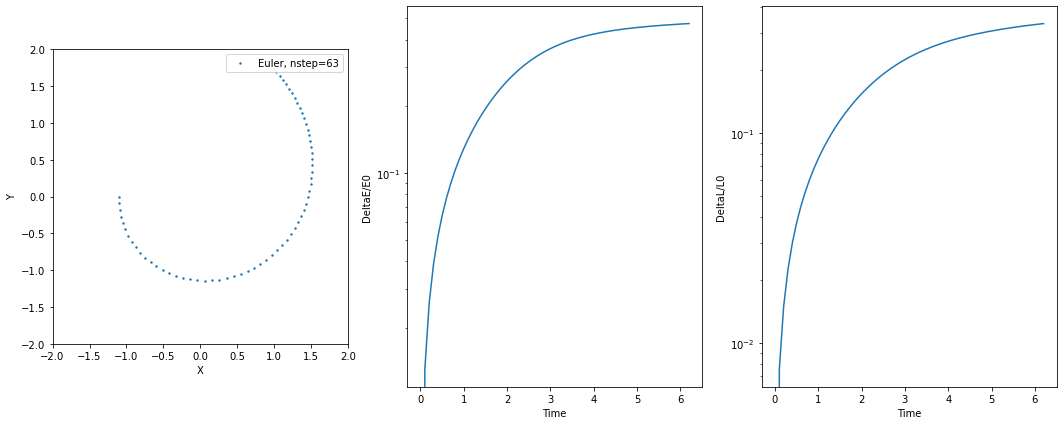

In [4]:
fig, ax = plt.subplots(ncols=3,figsize=(18,7))
plot_orbit(0.1,'Euler',0.1,ax, label='Euler')
init_plot()

Oof, what happened? Not only are the conserved quantities not at all conserved, the orbit isn't even closed! What gives?? Well, there's a reason Euler's method is the simplest. As can be seen below, one way to tackle this issue is by reducing the timestep. The unfortunate consequence of this is that it can significantly slow down your simulation, if, like in the case below, you need a lot of timesteps to get a reasonable answer. Furthermore, more timesteps can lead to more error (e.g. from floating point precision).

Finished initializing orbit
Finished initializing orbit


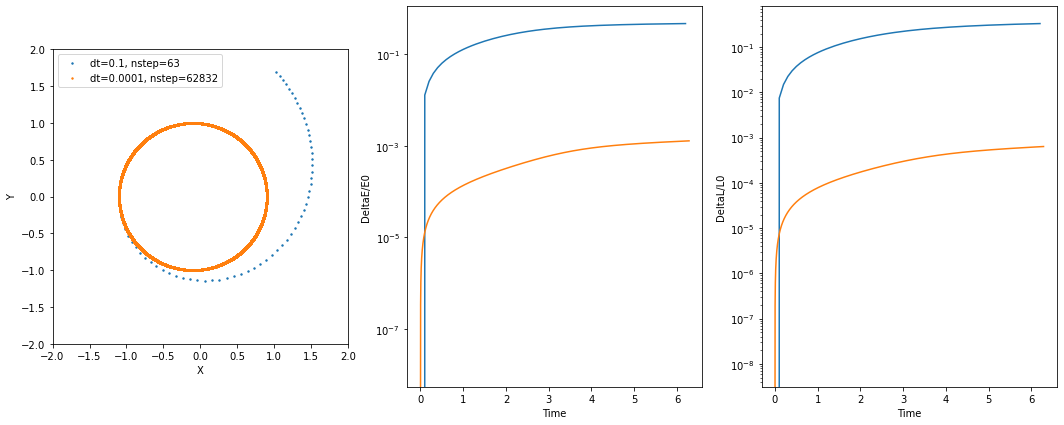

In [5]:
fig, ax = plt.subplots(ncols=3,figsize=(18,7))
plot_orbit(0.1,'Euler',0.1,ax, label='dt=0.1')
plot_orbit(0.1,'Euler',0.0001,ax, label='dt=0.0001')
init_plot()

Another way to get a more accurate result is by using a better integration scheme. Here, we use a method from the Runge-Kutta family of integration schemes. These work by evaluating the derivatives at intermediate points within a single timestep and combining the results in an intelligent way, as can be seen in the code below. The version used here is fourth-order, as it requires four fource evaluations per timestep, whereas Euler's method requires only one. "RK4" is known as the workhorse of ODE solving and is typically the first choice for approaching a problem.

    def RK4step(f,u,dt):
        k1 = dt*f(u)
        k2 = dt*f(u+0.5*k1)
        k3 = dt*f(u+0.5*k2)
        k4 = dt*f(u+k3)
        return u + (k1+2*k2+2*k3+k4)/6

Finished initializing orbit
Finished initializing orbit


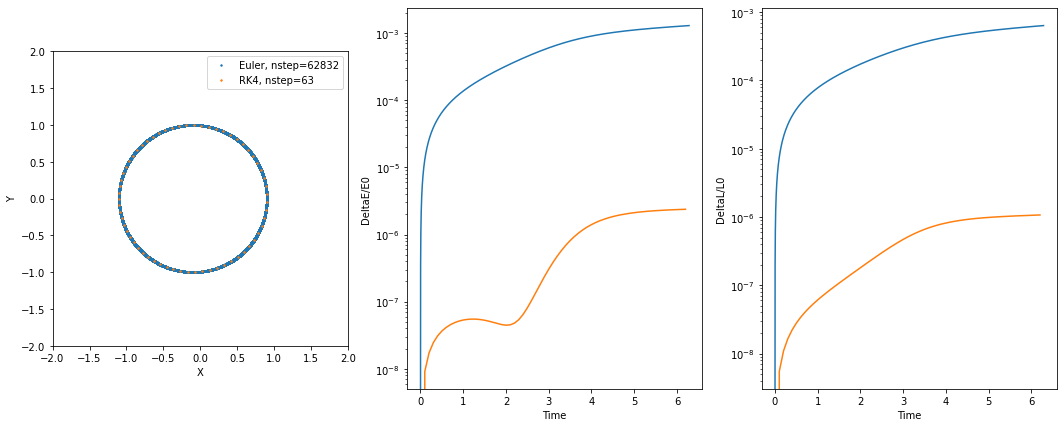

In [6]:
fig, ax = plt.subplots(ncols=3,figsize=(18,7))
plot_orbit(0.1,'Euler',0.0001,ax, label='Euler')
plot_orbit(0.1,'RK4',0.1,ax, label='RK4')
init_plot()

However, while RK4 is amazing, it won't always be sufficient. To demonstrate, let's break the code I wrote by simulating a very high eccentricity orbit. Close to pericenter, the speed of the particle is highest, which means that the distance, and thus the acceleration, is changing the fastest. It's obvious from looking that we'll need a very small timestep to resolve things properly. In the below example, since the timestep is too large in either instance, near pericenter the particle experiences a fictitious force from the extra work done by the extra velocity. As a result, it escapes the elliptical orbit and attains a hyperbolic trajectory. If the Universe is a simulation, perhaps interlopers like 'Oumuamua are just from timestep issues.

Finished initializing orbit
Finished initializing orbit


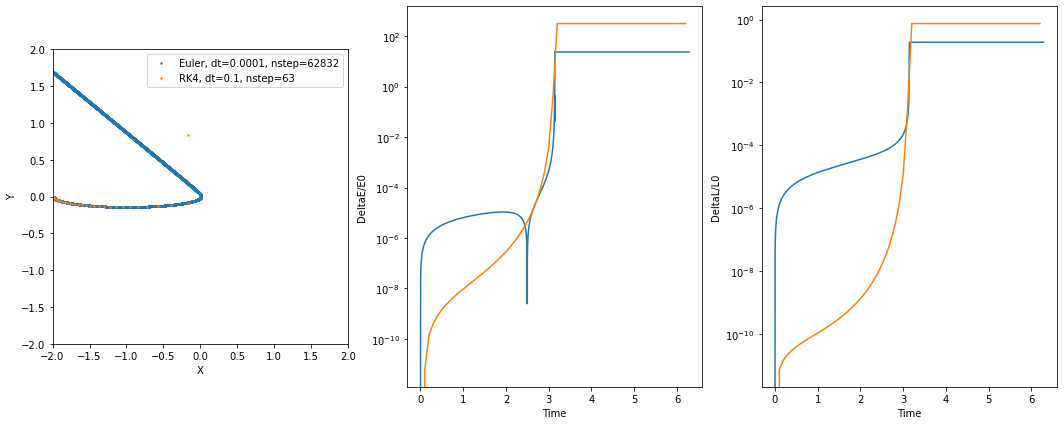

In [7]:
fig, ax = plt.subplots(ncols=3,figsize=(18,7))
plot_orbit(0.99,'Euler',0.0001,ax, label='Euler, dt=0.0001')
plot_orbit(0.99,'RK4',0.1,ax, label='RK4, dt=0.1')
init_plot()

On a more serious note, this takes us to our next solution, which is adaptive timestepping. In the previous example, we can see that the error was actually quite small at first. This is because near apocenter, the velocity is quite low, so we do not need small timesteps. So, a natural way to conserve resources is by making the timesteps small when they need to be small and big when they need to be big. The code for this is as follows

    yerr = np.ones(2)
    while (yerr>self.tol).any():
        y1 = stepfunc(self.dy_normal,y0,self.dt)
        y05 = stepfunc(self.dy_normal,y0,self.dt/2)
        y1p = stepfunc(self.dy_normal,y05,self.dt/2)
        yerr = np.abs(y1p-y1)
        self.dt = 0.9*self.dt*np.min((np.max((np.sqrt(0.5*self.tol/(1e-10+np.max(yerr))),0.3)),2))
    y1 = y1p

The procedure works by calculating two different versions of the solution, assuming the integration scheme is first order. y1 is the normal first order solution and y1p is a second order solution obtained by using half the timestep twice. We assume that the difference between the two solutions is equal to the error of the solution and calculate a new value for dt. If the error is larger than some tolerance, then dt is decreased accordingly and we repeat the procedure. Otherwise, dt can safely be increased and is used as the first guess for the next timestep. The 0.3 and 2 are used to prevent changes that are too drastic and 0.9 is used to ensure the guess is safely below the tolerance limit.

Note that this specific formula assumes the integration scheme is first order in this formulation. There is no reason it won't work for higher order methods like Runge-Kutta. However, it is horribly inefficient since it at least doubles the number of force calculations. While there are ways of doing this that aren't horribly inefficient (e.g. [SciPy's Runge-Kutta-Fehlberg](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.RK45.html)), this nevertheless serves as a good demonstration of the power of adaptive timestepping.

As can be seen in the example below, using adaptive timestepping indeed densely samples the solution near pericenter and increases the timestep further away, keeping the error at a tolerable level. Decreasing the tolerance leads to even better performance, but still at the cost of additional timesteps.

One caveat for this code is that, in principle, the tolerance should actually be vector valued, with a separate value for each equation. In this example, since we're using nondimensional quantities, the position and velocity coordinates should be around the same order of magnitude, so what I've done is fine. However, if one were combining units, such as AU for distance and km/s for velocity, then there could be some trouble.

Finished initializing orbit
Finished initializing orbit


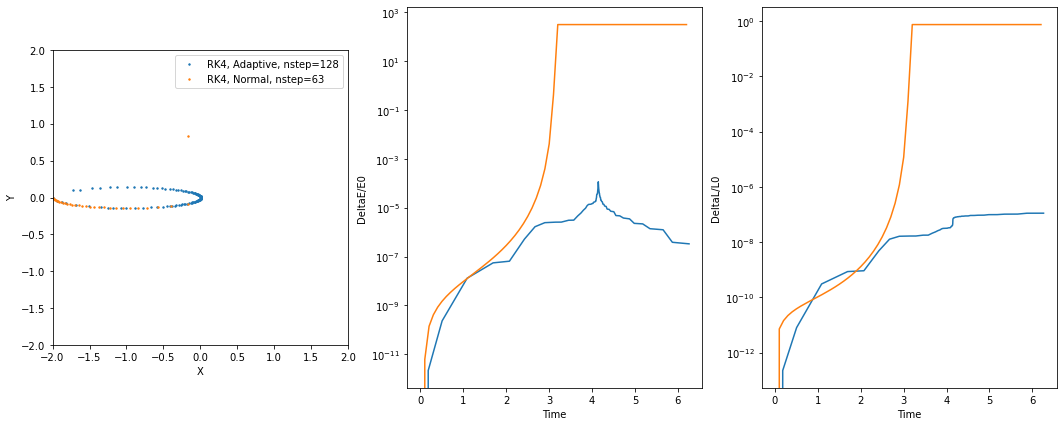

In [8]:
fig, ax = plt.subplots(ncols=3,figsize=(18,7))
plot_orbit(0.99,'RK4',0.1,ax, label='RK4, Adaptive',adaptive=True)
plot_orbit(0.99,'RK4',0.1,ax, label='RK4, Normal')
init_plot()

Finished initializing orbit
Finished initializing orbit


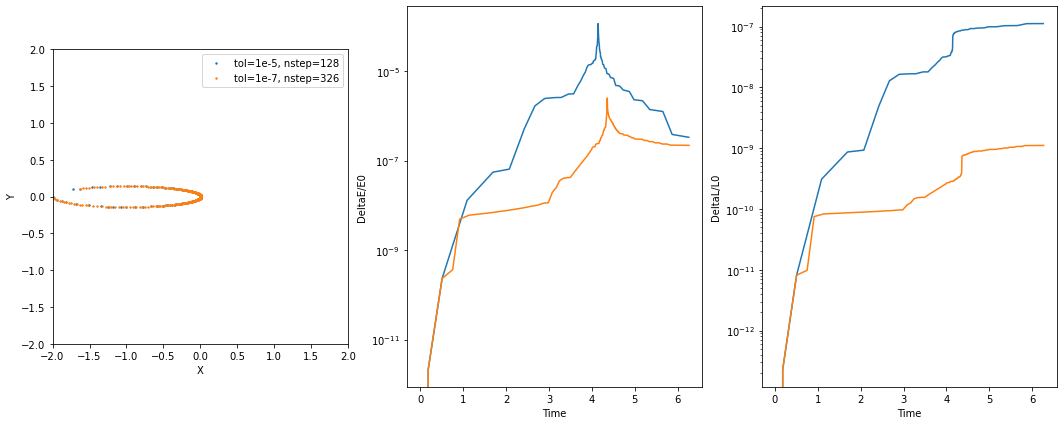

In [9]:
fig, ax = plt.subplots(ncols=3,figsize=(18,7))
plot_orbit(0.99,'RK4',0.1,ax, label='tol=1e-5',adaptive=True, tol=1e-5)
plot_orbit(0.99,'RK4',0.1,ax, label='tol=1e-7',adaptive=True, tol=1e-7)
init_plot()

The final approach I'll discuss here relates more generally to the idea of leveraging domain knowledge to solve the problem. For example, we know that the N-body problem is what is called a Hamiltonian system. A certain class of integrators called symplectic integrators leverage the phase space structure and can, by construction, preserve angular momentum to within machine precision. There are other examples, but this one is pretty nice. Before we get into it, let's discuss symmetries.

We know from Noether's Theorem that each symmetry corresponds to a conserved quantity. The two quantities we've been trying to conserve are energy and angular momentum. Energy corresponds to time invariance and angular momentum corresponds to 3D rotational invariance. It turns out that these correspond to conservation of $a$ and $e$ through the following equations:

$$ E/m = -\frac{GM}{2a} $$

$$ L/m = |\bar{r}\times\bar{v}| = h = \sqrt{GMa(1-e^2)} $$

However, just having these two quantities doesn't give us the full story. While we know the shape of the ellipse can't vary, these two equations alone can't tell us about the orientation of the ellipse since the angular momentum vector only specifies the plane of the orbit. Of course, one could always simply leverage rotational symmetry to initially orient the ellipse along convenient coordinate axes, but how can we guarantee that the ellipse doesn't rotate? In real life, we know that the perihelion of Mercury precesses due to a variety of factors.

Some of you might recall that Bertrand's Theorem gives us the result that orbits are closed for harmonic and inverse square forces. This in a sense answers the question but not in a way that's wholly satisfying, especially if your name is [Terence Tao](https://mathoverflow.net/questions/343955/is-there-a-high-level-reason-why-the-inverse-square-law-of-gravitation-yields-pe). In fact, there is one more relevant vector that's hiding around in the code, which is used to determine the position of the particle on the ellipse, known as the Laplace-Runge-Lenz or eccentricity vector.

    def convert_cartesian2kepler(self):
        r = np.linalg.norm(self.threepos)
        v = np.linalg.norm(self.threevel)
        h_vec = np.cross(self.threepos,self.threevel)
        e_vec = np.cross(self.threevel,h_vec) - self.threepos/r
        e = np.linalg.norm(e_vec)
        self.a = 1/(2/r - v**2)
        self.e = e
        f = np.arccos(np.dot(e_vec,self.threepos)/(e*r))
        if np.dot(self.threepos,self.threevel) < 0:
            self.f = 2*np.pi - f
        else:
            self.f = f

There are various definitions, but in the version used here, 

$$ \bar{e} = \frac{\bar{v}\times\bar{h}}{GM} - \hat{r} $$

the magnitude of the vector is simply the eccentricity. Regardless, all constructions of this vector lie in the orbital plane perpendicular to the angular momentum and point towards the orbit's pericenter. Per Bertand's Theorem, the Kepler problem is a special case where this vector is conserved, such that the position of the pericenter in absolute space does not change. We know now that there is this additional conserved quantity so there must be a symmetry hiding here. As it turns out, after some work, you can show that these ellipses in 3D space are actually projections of time parametrized circular motion in 4D space. In other words, the additional symmetry is actually the symmetry of 4D rotations! For a deeper intuitive explanation of how this works, see this great write up by [John Carlos Baez](https://johncarlosbaez.wordpress.com/2015/03/17/planets_in_the_4th_dimension/).

It turns out that this isn't just some mathematical curiosity. We can actually leverage these facts to regularize the equations of motion and remove the "singularity" that occurs when the test particle is near or at the origin, analagous to regularization in quantum field theory. This is known as the (Levi-Civita-)Kustaanheimo-Stiefel regularization.

There are two ingredients here, which can be applied in either order. First, since the symmetry is four dimensional, we want to transform our three vector $\bar{x}$ into something four dimensional. To do so, we turn to the language of spinors, or more specifically quaternions, and attempt to find quaternions $\bf{u}$ that satisfy the following (or other, similar) relations

$$ \bf{x} = \bf{u}^\star \hat{e} \bf{u} $$

Note that since we're adding a dimension, we're essentially tacking on a new degree of freedom. This introduces a number of ambiguities. In the above, $\bf{x}$ is the quaternion version of $\bar{x}$. We choose components of $\bf{x}$ to correspond to x, y, and z and let the fourth be zero. Depending on the choice you make, $\hat{e}$ can be one of $\hat{1},\hat{i},\hat{j},\hat{k}$. Furthermore, since we're tacking on a new dimension, we've introduced an additional degree of freedom, such that the transformation we choose is still nonunique, specifying not a point, but a whole ring of quaternions which corresponds to a great circle. For details, refer to either of [these](https://ui.adsabs.harvard.edu/abs/2009MNRAS.400..228S/abstract) [alternate](https://people.math.ethz.ch/~waldvoge/Papers/scotpaper.pdf) derivations. One version of the coordinate transformation is used here.

    # the transform is non-unique, so I used the version from
    # Appendix A of https://iopscience.iop.org/article/10.1086/429546/pdf
    x,y,z = self.threepos
    r = np.linalg.norm(self.threepos)
    vx,vy,vz = self.threevel

    if x<0:
        u2 = np.sqrt(0.5*(r-x))
        u3 = 0
        u1 = 0.5*y/u2
        u4 = 0.5*z/u2
    else:
        u1 = np.sqrt(0.5*(r+x))
        u4 = 0
        u2 = 0.5*y/u1
        u3 = 0.5*z/u1
    self.fourpos = np.array([u1,u2,u3,u4])

    uv1 = 0.5*(u1*vx + u2*vy + u3*vz)
    uv2 = 0.5*(-u2*vx + u1*vy + u4*vz)
    uv3 = 0.5*(-u3*vx - u4*vy +u1*vz)
    uv4 = 0.5*(u4*vx - u3*vy + u2*vz)
    self.fourvel = np.array([uv1,uv2,uv3,uv4])

As said before, the second ingredient is a time parametrization. This takes the form

$$ dt = r\,ds $$

so that instead of physical time, we use this new fictitous time $s$ for our integrations. With constant $ds$, large distances will cause the physical timestep $dt$ to increase and vice versa. In fact, we could regularize the equations of motion with this time parametrization alone, known as Burdet-Heggie regularization, but it turns out its performance is worse that what we're doing here.

Doing these transformations has several consequences for the equations of motion. First, we have three new entries in our array. One each for the new position and velocity components. The third is time, which we must now explicitly integrate according to the equation above. Second, the equation of motion we wrote down before in terms of $x$ can now be written in terms of $\bf{u}$. 

$$ \bf{u}'' + \frac{h}{2} \bf{u} = 0 $$

This is precisely the equation for a simple harmonic oscillator with frequency $\omega^2 = \frac{h}{2}$, where $h$ is the negative energy of the orbit. The primes connote derivatives with respect to the fictitious time $s$.

    x = u[:4]
    v = u[4:8]
    #t = u[8]
    h = -self.get_energy()
    r = np.linalg.norm(x)**2
    return np.concatenate((v,-x*h/2,r),axis=None)

As can be seen below in the comparison with the adaptive timestep method, using regularization not only outperforms using normal adaptive timesteps, but also with the same number of timesteps!

Finished initializing orbit
Finished initializing orbit


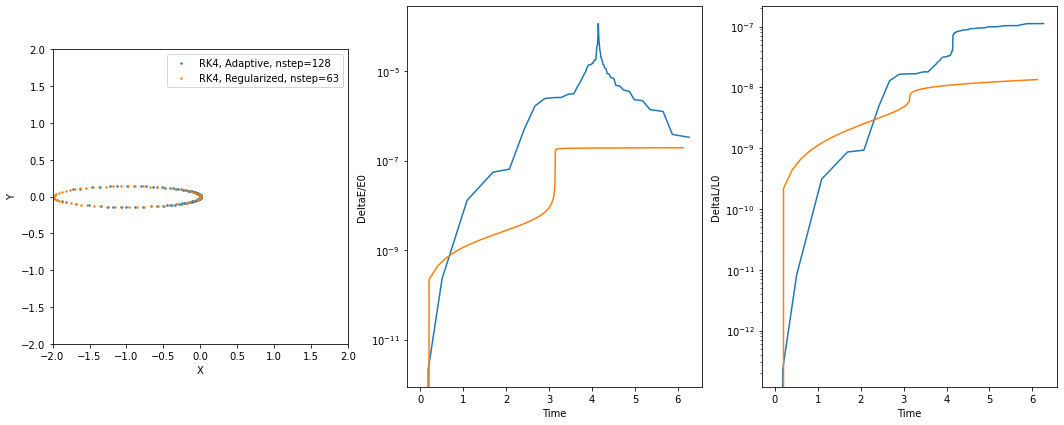

In [10]:
fig, ax = plt.subplots(ncols=3,figsize=(18,7))
plot_orbit(0.99,'RK4',0.1,ax, label='RK4, Adaptive',adaptive=True)
plot_orbit(0.99,'RK4',0.1,ax, label='RK4, Regularized',regularized=True)
init_plot()

As I stated previously, it is entirely possible to generalize all the methods in this notebook to $N>2$. However, it is nontrivial to extend regularization but it is possible and has [been done](https://ui.adsabs.harvard.edu/abs/1993CeMDA..57..439M/abstract). Nowadays, there exist more sophisticated but related methods to accomplish the same task to great effect. A history of regularization is presented [here](https://articles.adsabs.harvard.edu/pdf/2008IAUS..246..218M), along with the relevant references. These methods have proven to be effective in simulations up to hundreds of particles with similar mass. Other numerical tricks must be employed for larger systems. 

If you happen to be curious about other methods people use to simulate N-body systems in astrophysics, or you have additional questions, feel free to reach out!